# Defining our Area of Interest

This notebook serves as an exploration of of where we would be interested in mapping smallholder dry season irrigation. Considerations include: 
- Country boundaries
- The presence of agriculture, preferably specifically smallholder agriculture
- arid and semi-arid climate
- One clear rainy season and one clear dry season

In [10]:
import sys
import os

# Add the project root to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import numpy as np
import rasterio
from src.utils.utils import save_data, get_data_root
from shapely.geometry import box
import matplotlib.pyplot as plt

/var/folders/1f/_ptk0jz93h39qj25crwwtb0w0000gn/T/ipykernel_70209/787589935.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

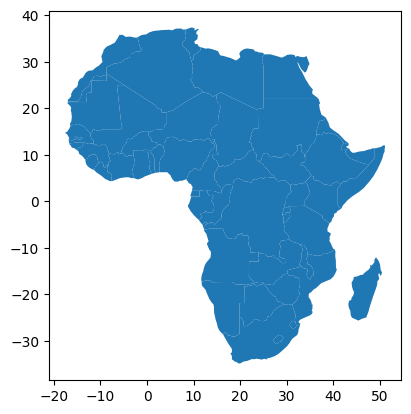

In [3]:
# Load county boundaries and only keep those in Sub-Saharan Africa

import geopandas as gpd

# Load country boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Africa
africa = world[world['continent'] == 'Africa']

# Display the filtered data
africa

# Plot the filtered data
africa.plot()

<Axes: >

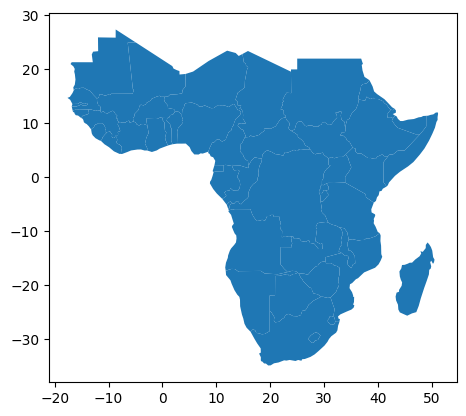

In [4]:
# Filter to Sub-Saharan Africa

northern_africa_countries = ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'W. Sahara']

ssa = africa[~africa['name'].isin(northern_africa_countries)]

# Display the filtered data
ssa.plot()

In [5]:
# save the filtered data

save_data(ssa, 'sampling/ssa_counties.json', "countries in Sub-Saharan Africa")

# Create and save a simple bounding box for Sub-Saharan Africa

# Get the bounding box of the GeoDataFrame
ssa_bbox = ssa.total_bounds  # [minx, miny, maxx, maxy]

# Create a bounding box polygon
bbox_polygon = box(ssa_bbox[0], ssa_bbox[1], ssa_bbox[2], ssa_bbox[3])

# Convert the bounding box to a GeoDataFrame
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=ssa.crs)

save_data(bbox_gdf, 'sampling/ssa_bbox.json', "bounding box for Sub-Saharan Africa")



In [6]:
# How many km2 are there in sub-saharan africa? 

# Calculate the area of Sub-Saharan Africa
ssa.to_crs(epsg=6933).area.sum() / 10**6  # in km^2

# About 24 million. 

24149688.441414084

In [8]:
# Check out regions that are agriculture

with rasterio.open(get_data_root() + '/sampling/raw/af-croplands-geotif/af_cropland.tif') as src:
    cropland_data = src.read(1)
    
    # Convert to binary (0s and 1s) based on the threshold > 0
    cropland_binary = (cropland_data > 0).astype(np.uint8)

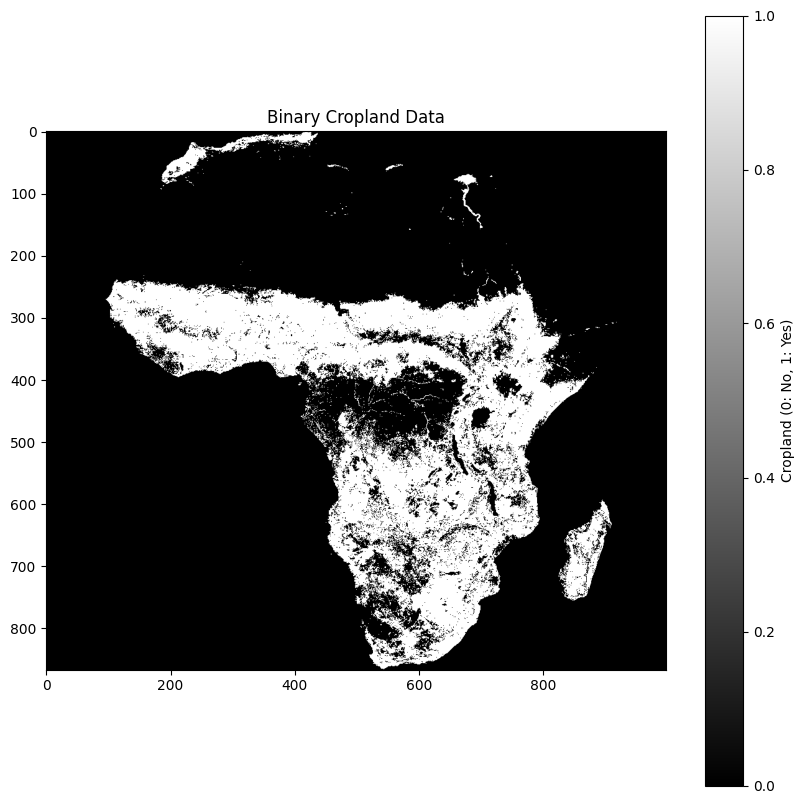

In [ ]:
# Plot the binary cropland data
plt.figure(figsize=(10, 10))
plt.imshow(cropland_binary, cmap='gray')
plt.title('Binary Cropland Data')
plt.colorbar(label='Cropland (0: No, 1: Yes)')
plt.show()

# probably better: "https://search.earthdata.nasa.gov/search/granules?p=C2763261633-LPCLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&q=C2763261633-LPCLOUD&tl=1738803151.687!3!!&lat=-2.110055565513534&long=-33.890625"

In [13]:
# Determine seasonality and only keep places with a clear dry season. Also map out when the dry season starts and how long it lasts. 

# First download 12 months of chirps climatological precip data

data_site = "https://data.chc.ucsb.edu/products/CHPclim/90N-90S.landonly/monthly/"

for month in range(1, 13):
    month_str = str(month).zfill(2)
    file_name = f"CHPclim.{month_str}.tif"
    os.system(f"wget {data_site}{file_name} -P {get_data_root()}/sampling/raw/chirps_climatology")

--2025-02-05 17:31:59--  https://data.chc.ucsb.edu/products/CHPclim/90N-90S.landonly/monthly/CHPclim.01.tif
wget: /Users/annaboser/.netrc:1: unknown token "“machine"
wget: /Users/annaboser/.netrc:1: unknown token "urs.earthdata.nasa.gov"
wget: /Users/annaboser/.netrc:1: warning: ‘login’ token appears before any machine name
wget: /Users/annaboser/.netrc:1: warning: ‘password’ token appears before any machine name
Resolving data.chc.ucsb.edu (data.chc.ucsb.edu)... 128.111.100.31
Connecting to data.chc.ucsb.edu (data.chc.ucsb.edu)|128.111.100.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103709376 (99M) [image/tiff]
Saving to: ‘/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset/data/sampling/raw/chirps_climatology/CHPclim.01.tif’

     0K .......... .......... .......... .......... ..........  0% 16.7M 6s
    50K .......... .......... .......... .......... ..........  0% 5.78M 11s
   100K .......... .......... .......... .......... .......... 

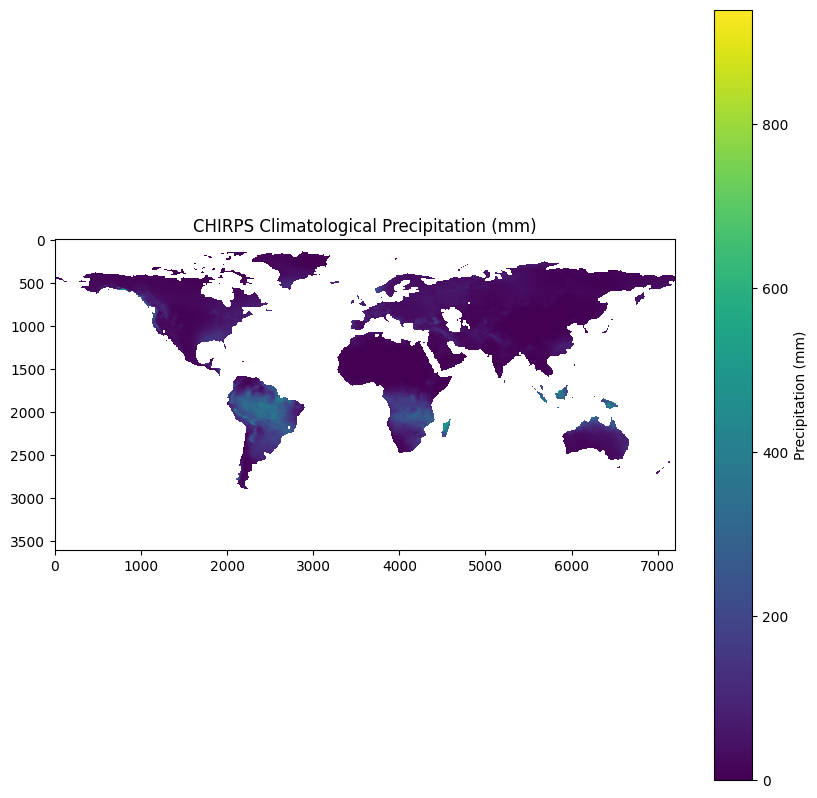

In [24]:
# Plot the first month of the data

with rasterio.open(get_data_root() + '/sampling/raw/chirps_climatology/CHPclim.01.tif') as src:

    chirps_data = src.read(1)
    
    crs = src.crs  # Coordinate Reference System
    transform = src.transform  # Affine transformation matrix
    bounds = src.bounds  # Bounding box of the raster

    # Mask out the no data values
    chirps_data = np.ma.masked_where(chirps_data == -9999, chirps_data)
    
    # Plot the data
    plt.figure(figsize=(10, 10))
    plt.imshow(chirps_data, cmap='viridis')
    plt.title('CHIRPS Climatological Precipitation (mm)')
    plt.colorbar(label='Precipitation (mm)')
    plt.show()

In [32]:
data_dir = f"{get_data_root()}/sampling/raw/chirps_climatology"

from rasterio.mask import mask
import geopandas as gpd
import numpy as np

# Function to trim CHIRPS data to SSA and return the trimmed data
def trim_to_ssa(input_tif, ssa_geom):
    with rasterio.open(input_tif) as src:
        out_image, _ = mask(src, ssa_geom.geometry, crop=True)
    return out_image[0]  # Return the first band

# Determine areas with a clear dry season
def identify_dry_season():
    monthly_precip = []
    for month in range(1, 13):
        month_str = str(month).zfill(2)
        file_name = f"CHPclim.{month_str}.tif"
        input_tif = os.path.join(data_dir, file_name)
        trimmed_data = trim_to_ssa(input_tif, ssa)
        monthly_precip.append(trimmed_data)

    # Stack monthly data (12, height, width)
    precip_stack = np.stack(monthly_precip)

    # Criteria: A clear dry season has at least 3 consecutive months with < 20 mm precipitation
    dry_season_mask = np.apply_along_axis(
        lambda x: np.any(np.convolve(x < 20, np.ones(3, dtype=int), mode='valid') == 3),
        axis=0,
        arr=precip_stack
    )

    return dry_season_mask

# Identify dry season mask
dry_season_mask = identify_dry_season()

Text(0.5, 1.0, 'Dry Season Mask')

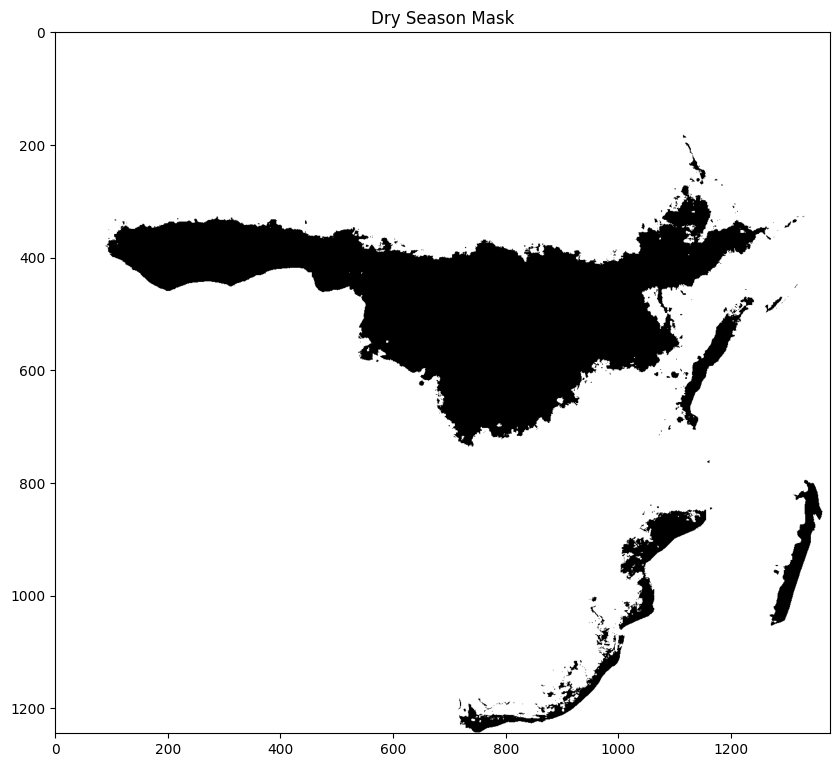

In [33]:
# plot the dry season mask with ssa boundaries on top

plt.figure(figsize=(10, 10))
plt.imshow(dry_season_mask, cmap='gray')
plt.title('Dry Season Mask')

In [ ]:
# Read in, coarsen from 30m to 1km grid (our unit of analysis), get the lat lons and agricultural coverage data out. 

# stitch the lat lons and ag coverage data together, add country information, and map it all out. 

# Sample from the data: random sample with some threshold of agriucltural land (any?? map out and decide) and also crop to zambia. (make this a function I guess)

Text(0.5, 1.0, 'Global Food Security Analysis Data')

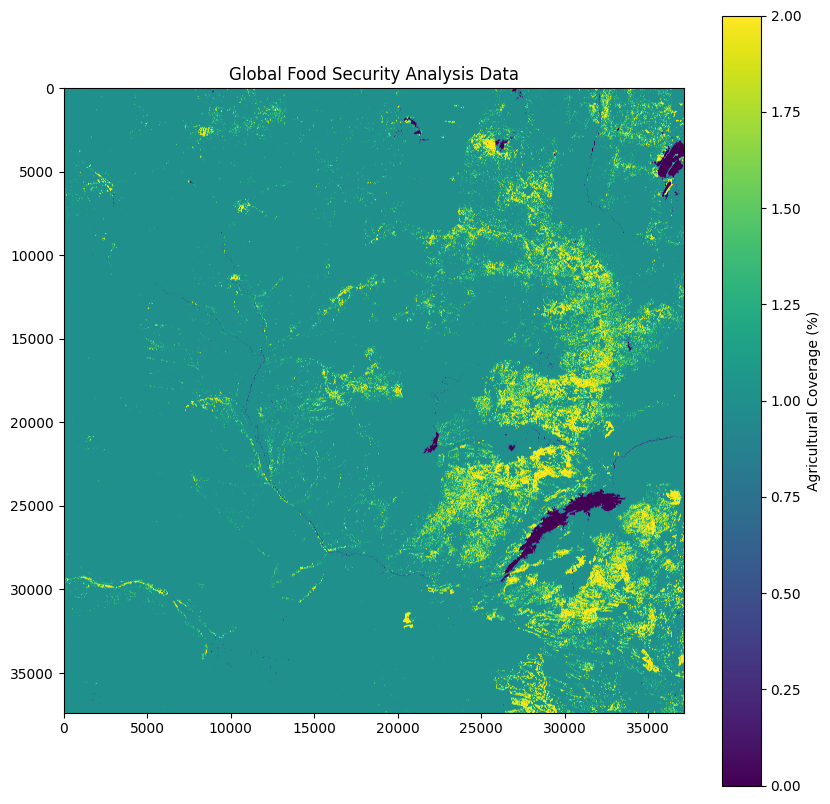

In [45]:
file = "GFSAD30AFCE_2015_S20E20_001_2017261090100.tif"

ag_data_loc = get_data_root() + '/sampling/raw/GFSAD/GFSAD30AFCE_001-20250206_011249/' + file
ag_data = rasterio.open(ag_data_loc)
ag_data = ag_data.read(1)

# plot the data
plt.figure(figsize=(10, 10))
plt.imshow(ag_data, cmap='viridis')
plt.colorbar(label='Agricultural Coverage (%)')
plt.title('Global Food Security Analysis Data')

Text(0.5, 1.0, 'Global Food Security Analysis Data')

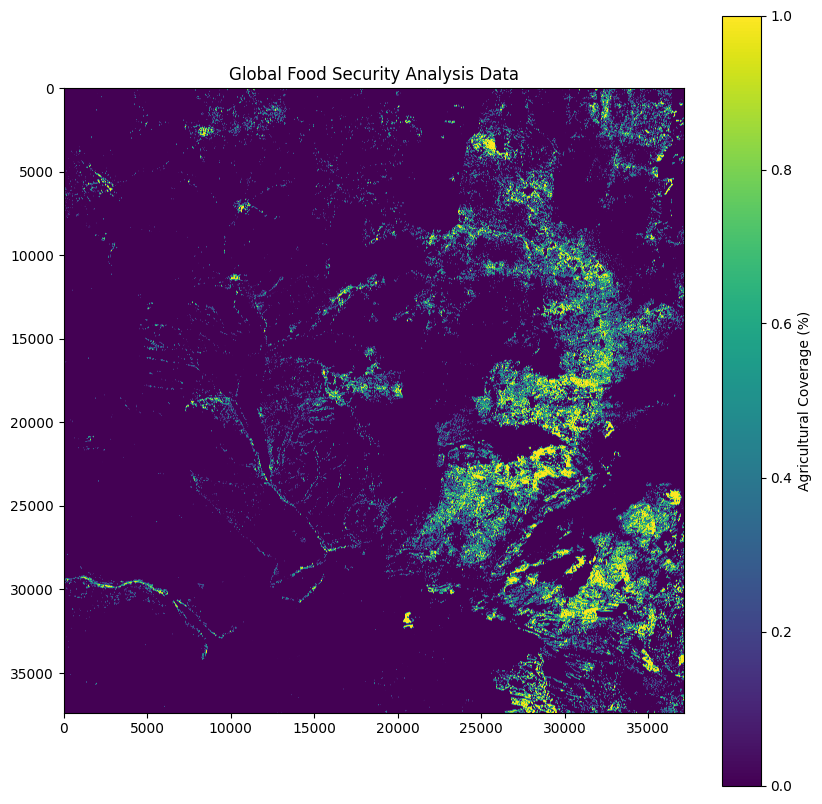

In [48]:
ag_data = ag_data == 2

plt.figure(figsize=(10, 10))
plt.imshow(ag_data, cmap='viridis')
plt.colorbar(label='Agricultural Coverage (%)')
plt.title('Global Food Security Analysis Data')

In [60]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling, transform_geom
import numpy as np
import pandas as pd
from pyproj import Transformer
import matplotlib.pyplot as plt

# File path
file = "GFSAD30AFCE_2015_S20E20_001_2017261090100.tif" # zambia
file = "GFSAD30AFCE_2015_N10E10_001_2017261090100.tif" # chad
ag_data_loc = get_data_root() + '/sampling/raw/GFSAD/GFSAD30AFCE_001-20250206_011249/' + file

print("Loading raster file...")
# Open the raster file
with rasterio.open(ag_data_loc) as src:
    ag_data = src.read(1)
    profile = src.profile
    transform = src.transform
    resolution = src.res
    crs = src.crs
    print("Profile:", profile)
    print("Transform:", transform)
    print("Resolution:", resolution)
    print("Coordinate Reference System (CRS):", crs)

print("Raster file loaded. Shape:", ag_data.shape)



Loading raster file...
Profile: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 37115, 'height': 37375, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.00026949458523585647, 0.0, 9.998788101420747,
       0.0, -0.00026949458523585647, 20.07141771919612), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
Transform: | 0.00, 0.00, 10.00|
| 0.00,-0.00, 20.07|
| 0.00, 0.00, 1.00|
Resolution: (0.00026949458523585647, 0.00026949458523585647)
Coordinate Reference System (CRS): GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Raster file loaded. Shape: (37375, 

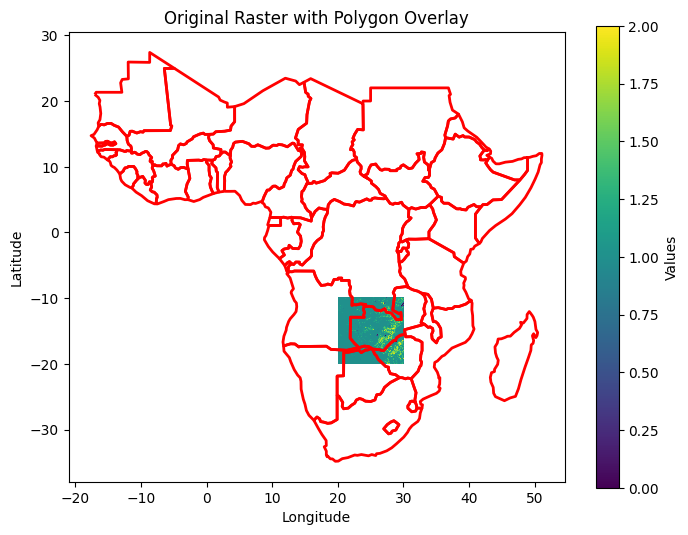

In [58]:
# Plot original raster with polygon overlay
plt.figure(figsize=(8, 6))
plt.title('Original Raster with Polygon Overlay')
plt.imshow(ag_data, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
ssa.boundary.plot(ax=plt.gca(), edgecolor='red', linewidth=2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Values')
plt.show()

In [77]:
from pyproj import CRS, Transformer

def get_utm_crs(lon, lat):
    """Returns the EPSG code for the appropriate UTM zone based on longitude and latitude."""
    zone = int((lon + 180) / 6) + 1
    if lat >= 0:
        epsg_code = 32600 + zone  # Northern Hemisphere
    else:
        epsg_code = 32700 + zone  # Southern Hemisphere
    return CRS.from_epsg(epsg_code)

# Example: Get UTM CRS for this raster
utm_crs = get_utm_crs(np.mean([src.bounds.left, src.bounds.right]), np.mean([src.bounds.bottom, src.bounds.top]))
print(utm_crs)


EPSG:32633


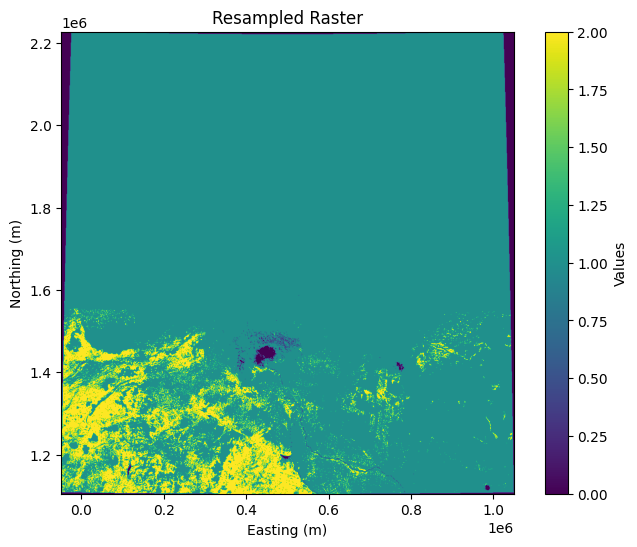

In [63]:
def reproject_and_resample(src_path, res):
    with rasterio.open(src_path) as src:
        # Determine UTM CRS based on the raster's center
        center_lon = (src.bounds.left + src.bounds.right) / 2
        center_lat = (src.bounds.top + src.bounds.bottom) / 2
        utm_crs = get_utm_crs(center_lon, center_lat)
        
        # Calculate the new transform and dimensions for 1 km resolution
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, utm_crs, src.width, src.height, *src.bounds, resolution=(res, res)
        )

        # Prepare an empty array for the resampled raster
        resampled_raster = np.empty((height, width), dtype=src.dtypes[0])

        # Reproject and resample to 1 km in memory
        rasterio.warp.reproject(
            source=rasterio.band(src, 1),
            destination=resampled_raster,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=utm_crs,
            resampling=rasterio.warp.Resampling.nearest
        )

        return resampled_raster, transform, utm_crs

resampled_raster, transform, utm_crs = reproject_and_resample(ag_data_loc, 1000)

# Plot the resampled raster
plt.figure(figsize=(8, 6))
plt.title('Resampled Raster')
plt.imshow(resampled_raster, cmap='viridis', extent=[transform[2], transform[2] + transform[0] * resampled_raster.shape[1],
                                                      transform[5] + transform[4] * resampled_raster.shape[0], transform[5]])
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.colorbar(label='Values')
plt.show()

Original CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Original Bounds: BoundingBox(left=19.998923675767674, bottom=-20.07141771919612, right=30.001215206796488, top=-9.999057596005983)
Original Resolution: (0.00026949458523585647, 0.00026949458523585647)
Binary mask created. Non-zero count: 101074494


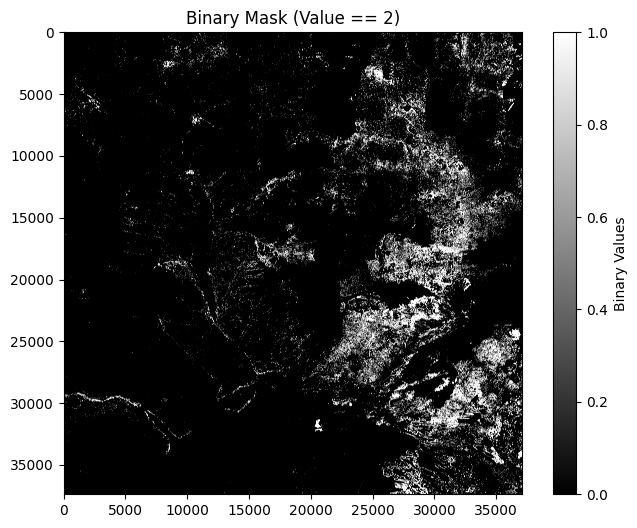

UTM CRS Selected: EPSG:32735
Resampled Dimensions: 1099 1130


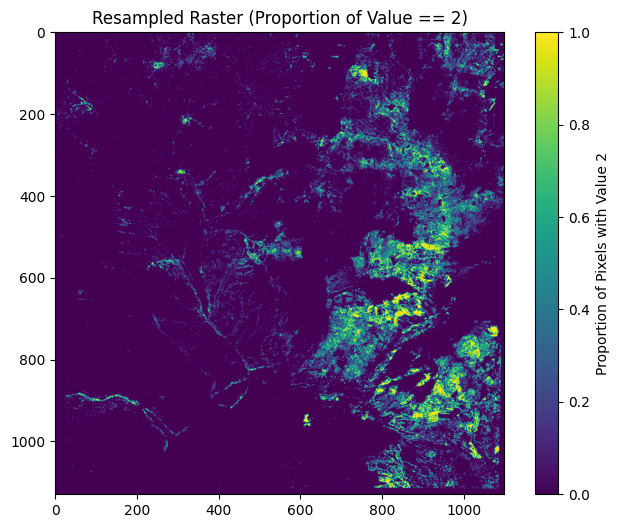

In [78]:
import rasterio
import numpy as np
import pandas as pd
import pyproj

# File path
file = "GFSAD30AFCE_2015_S20E20_001_2017261090100.tif" # zambia
ag_data_loc = get_data_root() + '/sampling/raw/GFSAD/GFSAD30AFCE_001-20250206_011249/' + file


src_path = ag_data_loc
res = 1000

with rasterio.open(src_path) as src:
    print("Original CRS:", src.crs)
    print("Original Bounds:", src.bounds)
    print("Original Resolution:", src.res)

    # Read the original raster
    data = src.read(1)

    # Create binary mask where value == 2
    binary_mask = (data == 2).astype(np.uint8)
    print("Binary mask created. Non-zero count:", np.count_nonzero(binary_mask))

    # Plot original binary mask
    plt.figure(figsize=(8, 6))
    plt.title('Binary Mask (Value == 2)')
    plt.imshow(binary_mask, cmap='gray')
    plt.colorbar(label='Binary Values')
    plt.show()

    # Determine UTM CRS based on the raster's center
    center_lon = (src.bounds.left + src.bounds.right) / 2
    center_lat = (src.bounds.top + src.bounds.bottom) / 2
    utm_crs = get_utm_crs(center_lon, center_lat)
    print("UTM CRS Selected:", utm_crs)

    # Calculate the new transform and dimensions for the specified resolution
    transform, width, height = rasterio.warp.calculate_default_transform(
        src.crs, utm_crs, src.width, src.height, *src.bounds, resolution=(res, res)
    )
    print("Resampled Dimensions:", width, height)

    # Prepare an empty array for the resampled raster
    resampled_raster = np.empty((height, width), dtype=np.float32)

    # Reproject and resample in memory using average resampling
    rasterio.warp.reproject(
        source=binary_mask,
        destination=resampled_raster,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=utm_crs,
        resampling=rasterio.warp.Resampling.average
    )

    # Plot resampled raster
    plt.figure(figsize=(8, 6))
    plt.title('Resampled Raster (Proportion of Value == 2)')
    plt.imshow(resampled_raster, cmap='viridis')
    plt.colorbar(label='Proportion of Pixels with Value 2')
    plt.show()


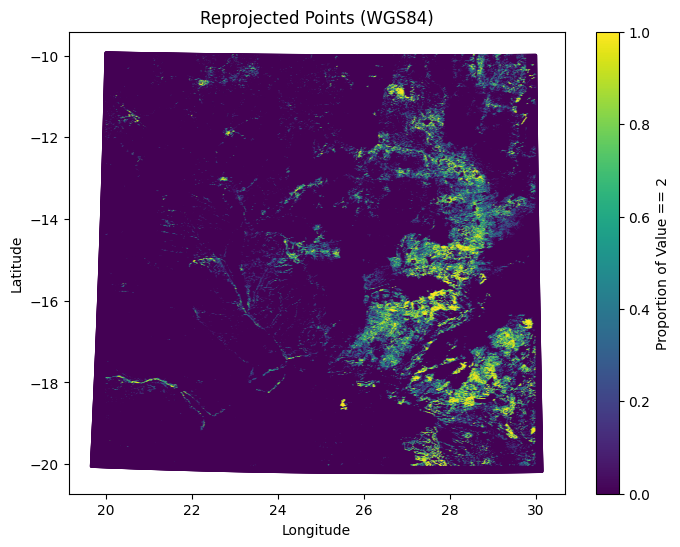

In [79]:
# Extract UTM coordinates (center of each pixel)
rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

# Convert UTM coordinates to WGS84 (latitude, longitude)
transformer = pyproj.Transformer.from_crs(utm_crs, "EPSG:4326", always_xy=True)
longitudes, latitudes = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())

# Debug: Plot points to verify geolocation
plt.figure(figsize=(8, 6))
plt.scatter(longitudes, latitudes, c=resampled_raster.flatten(), cmap='viridis', s=1)
plt.colorbar(label='Proportion of Value == 2')
plt.title('Reprojected Points (WGS84)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Flatten values for DataFrame
values = resampled_raster.flatten()

# Create DataFrame with lat/lon
df = pd.DataFrame({
    'latitude': latitudes,
    'longitude': longitudes,
    'value': values
})

# Optional: Filter out zero values if needed
df = df[df['value'] > 0]

In [80]:
df.head()

latitude  longitude     value
643 -10.001607  25.854024  0.007633
644 -10.001638  25.863146  0.204737
646 -10.001700  25.881392  0.174156
749 -10.003532  26.821148  0.145260
750 -10.003537  26.830273  0.085155

In [81]:
save_data(df, 'sampling/grid/agriculture_grid_S20E20.csv', description='Agriculture Data S20E20 Resampled to 1km Grid', file_format='csv')